### **SYDE522 - Predict Energy Behaviour**

In [41]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

# Modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 100)

In [3]:
# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
# Helper functions
def display_df(df, name):
    '''Display df shape and first row '''
    print(f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns')
    display(df.head(1))

In [5]:
DATA_DIR = "/kaggle/input/predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

# Location from https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
location = (pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

In [6]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

train data has 2018352 rows and 9 columns


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


client data has 41919 rows and 7 columns


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


historical weather data has 1710802 rows and 18 columns


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


forecast weather data has 3424512 rows and 18 columns


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


electricity prices data has 15286 rows and 4 columns


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


gas prices data has 637 rows and 5 columns


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


location data data has 75 rows and 3 columns


,county,longitude,latitude
0,0,24.2,59.1


### **Data Processing**
Data processing techniques based on code [created by rafiko1](http://).

In [24]:
class FeatureProcessor():
    def __init__(self):
        # Define columns to join on for different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        self.gas_join = ['data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']
        
    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 
    
    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df

    def create_data_features(self, data):
        '''Create time-related features from main data'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client

    def create_historical_weather_features(self, historical_weather):
        '''Create selected weather features'''
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        return historical_weather

    def create_electricity_features(self, electricity):
        '''Create electricity price features'''
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )                
        return electricity
    
    def create_forecast_weather_features(self, forecast_weather):
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )


        forecast_weather['datetime'] = pd.to_datetime(forecast_weather['datetime'])
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_localize('UTC')  # Localize to UTC
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_convert('Europe/Brussels')  # Convert to 'Europe/Brussels' timezone
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_localize(None)

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        )

        # Group by & calculate aggregate stats
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index()

        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)
        return forecast_weather
    
    def create_gas_features(self, gas):
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2

        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas,
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )
        return gas

    def process_features(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)

        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        print(df[['datetime', 'county', 'data_block_id']].dtypes)
        print(forecast_weather[['datetime', 'county', 'data_block_id']].dtypes)

        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)

        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df
    
    def process_features_XGBoost(self, data, client, historical_weather, forecast_weather, electricity):
        '''Process and combine features from all data sources'''
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        electricity = self.create_electricity_features(electricity)

        # Merge all features into a single DataFrame
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        return df
    
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [33]:
# Create features
N_day_lags = 3

# Initialize the feature processor
processor = FeatureProcessor()

# Process the features
features = processor.process_features(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(features.copy(), N_day_lags = N_day_lags)
print(f'There are {df.shape[1]} features: {list(df.columns)}')

datetime         datetime64[ns]
county                    int64
data_block_id             int64
dtype: object
datetime         datetime64[ns]
county                  float64
data_block_id             int64
dtype: object
There are 59 features: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'date_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f

In [36]:
# List of columns to be removed
no_features = ['date',
               'datetime',
               'forecast_date_electricity',
               'date_client',
               'origin_date_electricity',
               'forecast_date_gas',
               'origin_date_gas']

remove_columns = ['target']

# Remove the specified columns from the DataFrame
df_dropped = df.drop(columns=no_features) 
features = [f for f in df_dropped.columns if f not in remove_columns]
target = ['target']
print(f'There are {df_dropped.shape[1]} features: {list(df_dropped.columns)}')

df_dropped = df_dropped.dropna()

There are 52 features: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'data_block_id', 'row_id', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean

## **Training**

In [38]:
train_block_id = list(range(0, 446))
val_block_id = list(range(446, 542))
test_block_id = list(range(542, 638))

tr = df_dropped[df_dropped['data_block_id'].isin(train_block_id)] 
val = df_dropped[df_dropped['data_block_id'].isin(val_block_id)] 
test = df_dropped[df_dropped['data_block_id'].isin(test_block_id)] 

x_train = []
y_train = []
x_val = []
y_val = []

x_train = tr[features]
y_train = tr[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]
y_test = test[target]

### **Linear Regression**

In [39]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 129.96174331471673


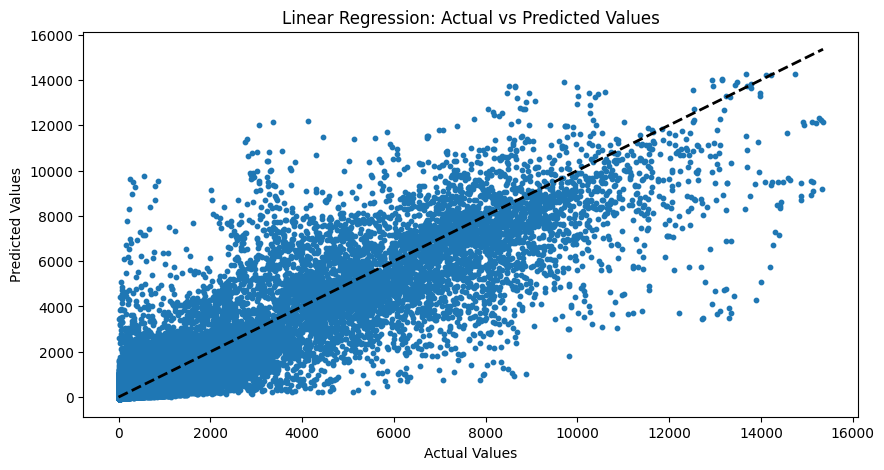

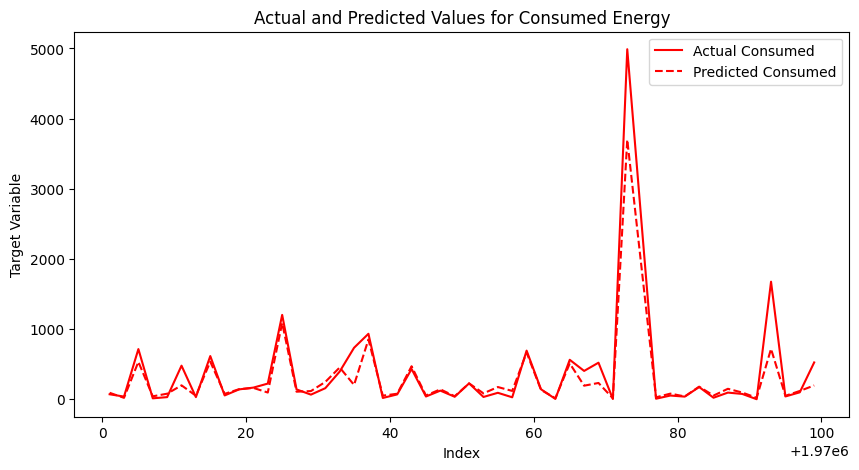

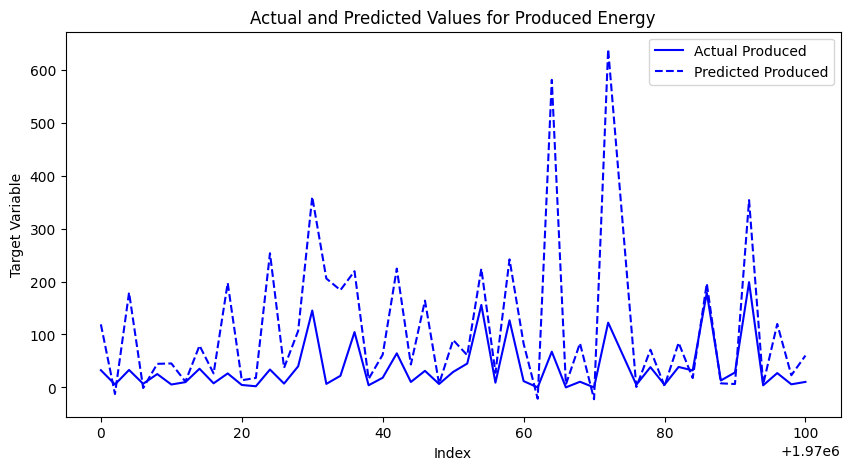

In [40]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=10)  # Scatter plot for actual vs predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.title('Linear Regression: Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Choose the range of indices to focus on
start_index = 1.97e6  # Replace with your actual start index
end_index = 1.9701e6    # Replace with your actual end index

# Create a boolean mask for the consumed and produced energy within the specified range
consumed_range = (x_test['is_consumption'] == 1) & (y_test.index >= start_index) & (y_test.index <= end_index)
produced_range = (x_test['is_consumption'] == 0) & (y_test.index >= start_index) & (y_test.index <= end_index)

# Plot for consumed energy in the specified range
plt.figure(figsize=(10, 5))
plt.plot(y_test[consumed_range].index, y_test[consumed_range], 'r-', label='Actual Consumed')
plt.plot(y_test[consumed_range].index, y_pred[consumed_range], 'r--', label='Predicted Consumed')
plt.title('Actual and Predicted Values for Consumed Energy')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test[produced_range].index, y_test[produced_range], 'b-', label='Actual Produced')
plt.plot(y_test[produced_range].index, y_pred[produced_range], 'b--', label='Predicted Produced')
plt.title('Actual and Predicted Values for Produced Energy')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## **XGBoost**

In [25]:
# Create features
N_day_lags = 3

# Initialize the feature processor
processor = FeatureProcessor()

# Process the features
features = processor.process_features(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(features.copy(), N_day_lags = N_day_lags)
print(f'There are {df.shape[1]} features: {list(df.columns)}')

datetime         datetime64[ns]
county                    int64
data_block_id             int64
dtype: object
datetime         datetime64[ns]
county                  float64
data_block_id             int64
dtype: object
There are 59 features: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'date_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f

In [32]:
# List of columns to be removed
no_features = ['date',
               'datetime',
               'forecast_date_electricity',
               'date_client',
               'origin_date_electricity',
               'forecast_date_gas',
               'origin_date_gas',
               'row_id', 
               'prediction_unit_id']

remove_columns = ['target']

# Remove the specified columns from the DataFrame
df_sorted = df.sort_values(by=["datetime"], ascending=True)
df_dropped = df_sorted.drop(columns=no_features)
features = [f for f in df_dropped.columns if f not in remove_columns]
target = ['target']
print(f'There are {df_dropped.shape[1]} features: {list(df_dropped.columns)}')

There are 50 features: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'data_block_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 

In [33]:
df_RGBoost = df_dropped.dropna(subset=target).reset_index(drop=True)

train_block_id = list(range(0, 446))
val_block_id = list(range(446, 542))
test_block_id = list(range(542, 638))

tr = df_RGBoost[df_RGBoost['data_block_id'].isin(train_block_id)]
val = df_RGBoost[df_RGBoost['data_block_id'].isin(val_block_id)] 
test = df_RGBoost[df_RGBoost['data_block_id'].isin(test_block_id)] 
        
x_train = []
y_train = []
x_val = []
y_val = []

x_train_og = tr[features]
y_train_og = tr[target]
x_val_og = val[features]
y_val_og = val[target]
        
x_train = np.array(x_train_og).astype('float32')
y_train = np.array(y_train_og).astype('float32')
x_val = np.array(x_val_og).astype('float32')
y_val = np.array(y_val_og).astype('float32')

In [34]:
clf = xgb.XGBRegressor(
                        device = device,
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 1500,
                        early_stopping_rounds=100,
                        learning_rate=0.1,
                        max_depth=None,
                       )

In [35]:
clf.fit(X = x_train, 
        y = y_train, 
        eval_set = [(x_train, y_train), (x_val, y_val)], 
        verbose=False #True
       )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

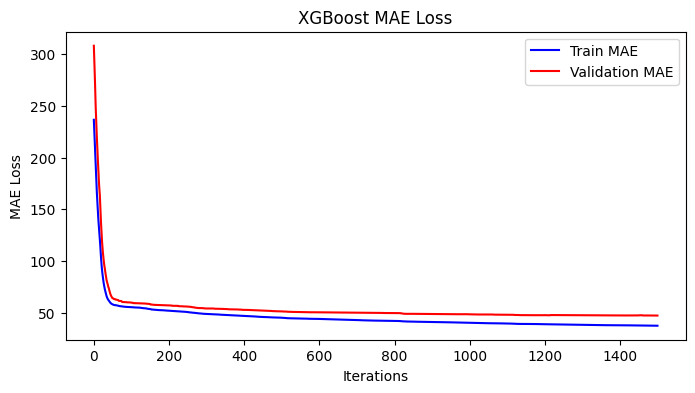

Early stopping on best iteration #1499 with MAE error on validation set of 47.37
with MAE error on training set of 37.56
last train MAE: 37.56
last val MAE: 47.37


In [36]:
# Plot RMSE
results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, "b-", label="Train MAE")
ax.plot(x_values, val_mae, "r-", label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.xlabel("Iterations")
plt.title("XGBoost MAE Loss")
plt.show()
print(f'Early stopping on best iteration #{clf.best_iteration} with MAE error on validation set of {clf.best_score:.2f}')
print(f'with MAE error on training set of {train_mae[clf.best_iteration]:.2f}')

print(f'last train MAE: {train_mae[-1]:.2f}')
print(f'last val MAE: {val_mae[-1]:.2f}')

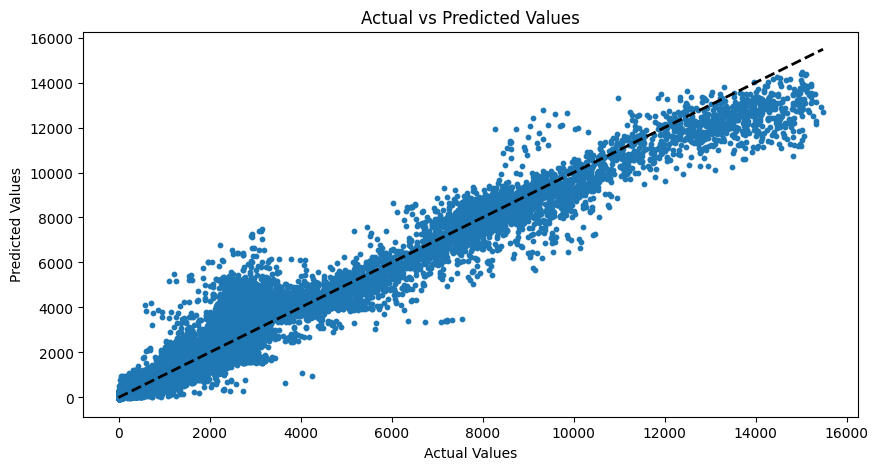

In [37]:
# Generate predictions
y_pred = clf.predict(x_val)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, s=10)  # Scatter plot for actual vs predictions
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

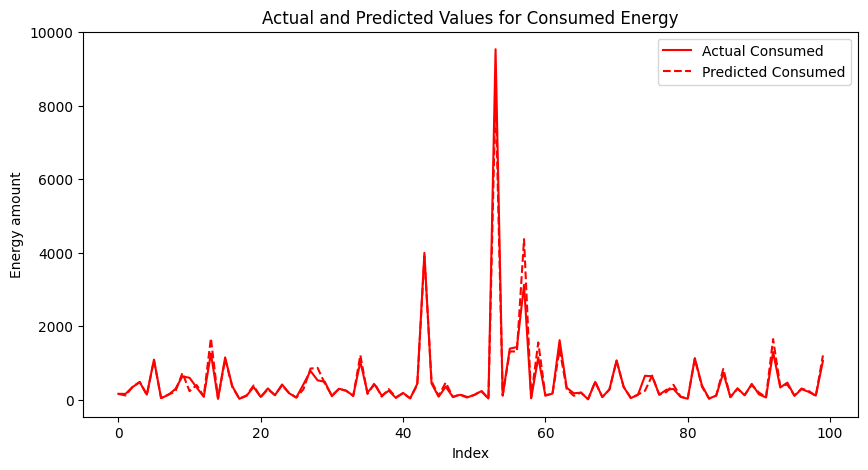

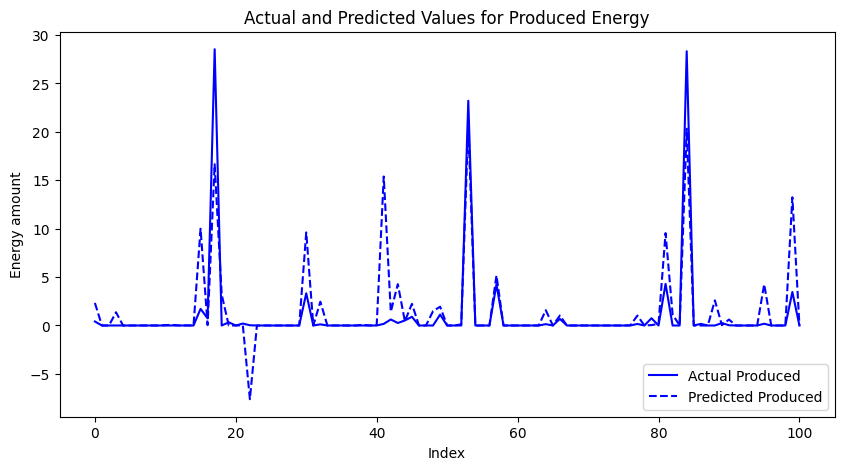

In [38]:
# Choose the range of indices to focus on
start_index = 90000  # Replace with your actual start index
end_index = 90200    # Replace with your actual end index

# Create a boolean mask for the consumed and produced energy within the specified range
indices = np.arange(len(y_val))

# Create boolean masks based on the conditions
consumed_range = (x_val_og['is_consumption'] == 1) & (indices >= start_index) & (indices <= end_index)
produced_range = (x_val_og['is_consumption'] == 0) & (indices >= start_index) & (indices <= end_index)

# Plot for consumed energy in the specified range
plt.figure(figsize=(10, 5))
plt.plot(y_val[consumed_range], 'r-', label='Actual Consumed')
plt.plot(y_pred[consumed_range], 'r--', label='Predicted Consumed')
plt.title('Actual and Predicted Values for Consumed Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_val[produced_range], 'b-', label='Actual Produced')
plt.plot(y_pred[produced_range], 'b--', label='Predicted Produced')
plt.title('Actual and Predicted Values for Produced Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()

### **MLP**

In [42]:
train_block_id = list(range(0, 446))
val_block_id = list(range(446, 542))
test_block_id = list(range(542, 638))

df_FC = df[df['target'].notnull()].reset_index(drop=True)
tr = df_FC[df_FC['data_block_id'].isin(train_block_id)]
val = df_FC[df_FC['data_block_id'].isin(val_block_id)] 
test = df_FC[df_FC['data_block_id'].isin(test_block_id)] 
        
x_train = []
y_train = []
x_val = []
y_val = []

x_train_og = tr[features]
y_train_og = tr[target]
x_val_og = val[features]
y_val_og = val[target]
        
x_train = np.array(x_train_og).astype('float32')
y_train = np.array(y_train_og).astype('float32')
x_val = np.array(x_val_og).astype('float32')
y_val = np.array(y_val_og).astype('float32')
        
x_train = np.nan_to_num(x_train)
x_val = np.nan_to_num(x_val)

In [44]:
def train(x_train, y_train, x_val, y_val):
    
        model = {
            "model": None,
            "history": None,
            "y_pred": None}
        
        model['model'] = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, input_shape=(len(features),), activation='relu'),
            tf.keras.layers.Dense(64, input_shape=(len(features),), activation='relu'),
            tf.keras.layers.Dense(128, input_shape=(len(features),), activation='relu'),
            tf.keras.layers.Dense(256, input_shape=(len(features),), activation='relu'),
            #tf.keras.layers.Dense(32, activation='relu'),
            #tf.keras.layers.Dropout(0.1),
            #tf.keras.layers.Dense(64, activation='relu'),
            #tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        model['model'].compile(optimizer='adam', loss='mae', metrics=['mae'])
        model['history'] = model['model'].fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stop])
        y_pred = model['model'].predict(x_val)
        model['y_pred'] = y_pred
        model['y_val'] = y_val
        
        return model, y_pred

model, y_pred = train(x_train, y_train, x_val, y_val)

Epoch 1/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 75.7255 - mae: 75.7255 - val_loss: 58.4502 - val_mae: 58.4502
Epoch 2/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 65.8195 - mae: 65.8195 - val_loss: 58.6419 - val_mae: 58.6419
Epoch 3/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 61.9429 - mae: 61.9429 - val_loss: 55.6603 - val_mae: 55.6603
Epoch 4/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 59.9411 - mae: 59.9411 - val_loss: 56.6496 - val_mae: 56.6496
Epoch 5/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 57.9355 - mae: 57.9355 - val_loss: 51.8805 - val_mae: 51.8805
Epoch 6/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 56.6737 - mae: 56.6737 - val_loss: 52.3089 - val_mae: 52.3089
Epoch 7/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 54.8558 - mae: 54.8558 - val_loss: 52.4393 - val_mae: 52.4393
Epoch 8/10
21945/21945 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 54.0191 - mae: 54.0191 - val_loss: 49.2324 - v

<Figure size 640x480 with 0 Axes>

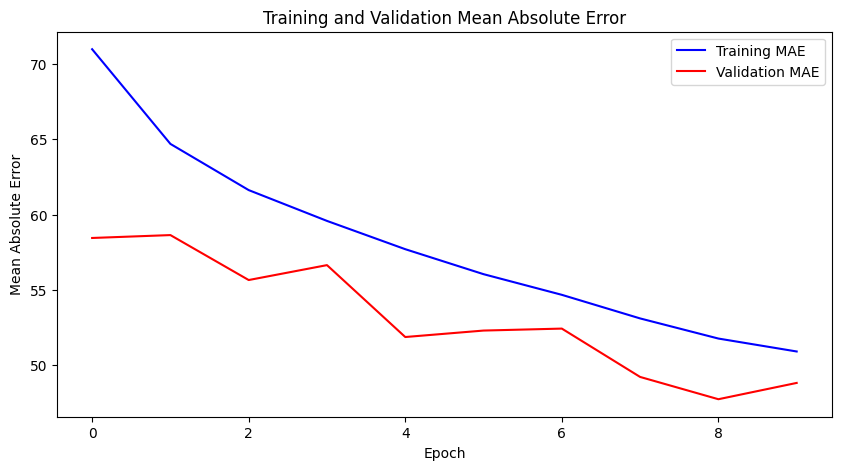

In [45]:
plt.figure()
plt.figure(figsize=(10, 5))
plt.plot(model["history"].history['mae'], 'b', label='Training MAE')
plt.plot(model["history"].history['val_mae'],'r', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show() 

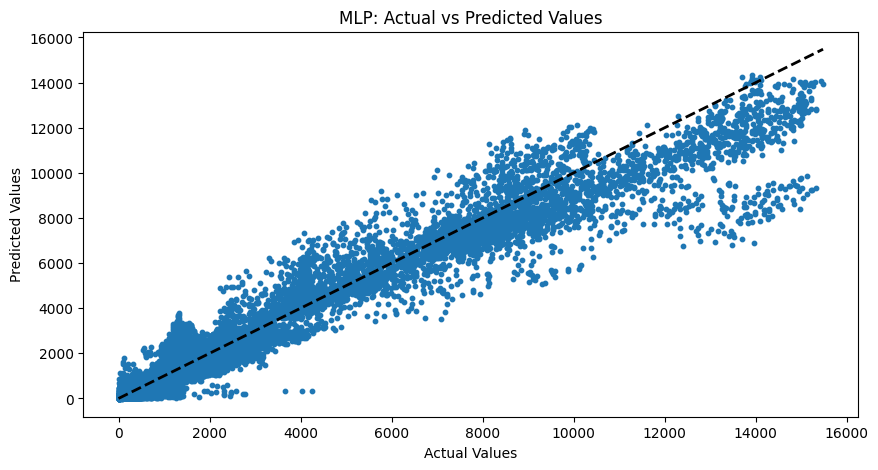

In [46]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, s=10)  # Scatter plot for actual vs predictions
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.title('MLP: Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

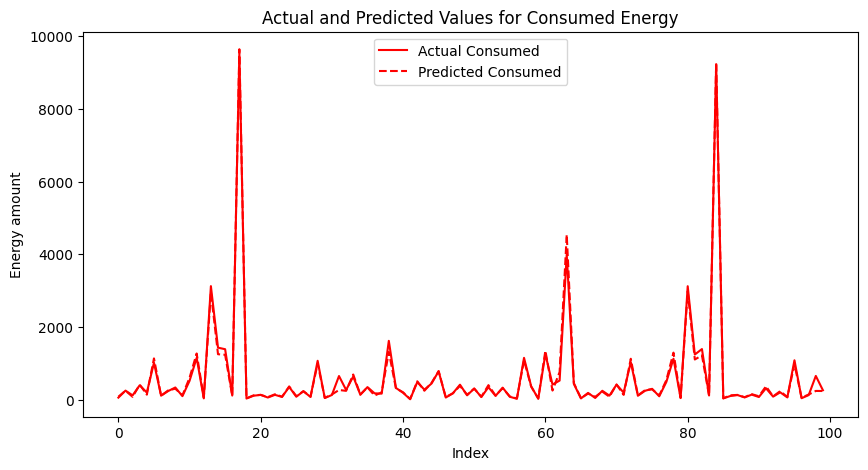

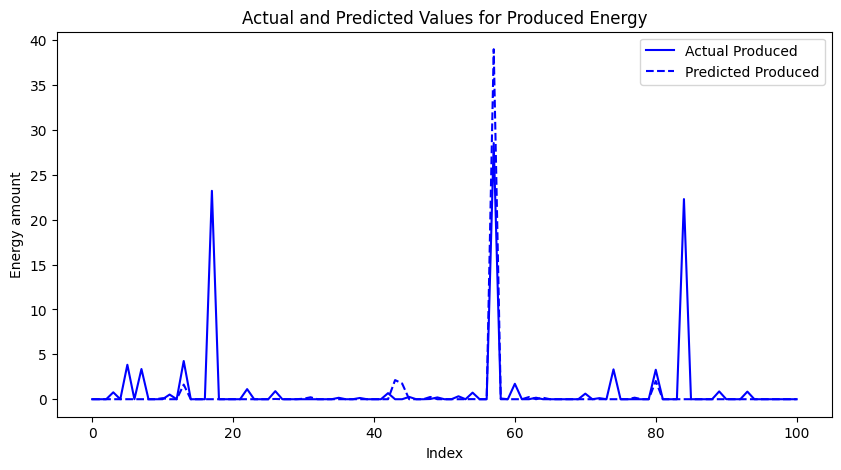

In [47]:
# Choose the range of indices to focus on
start_index = 90000  # Replace with your actual start index
end_index = 90200    # Replace with your actual end index

# Create a boolean mask for the consumed and produced energy within the specified range
indices = np.arange(len(y_val))

# Create boolean masks based on the conditions
consumed_range = (x_val_og['is_consumption'] == 1) & (indices >= start_index) & (indices <= end_index)
produced_range = (x_val_og['is_consumption'] == 0) & (indices >= start_index) & (indices <= end_index)

# Plot for consumed energy in the specified range
plt.figure(figsize=(10, 5))
plt.plot(y_val[consumed_range], 'r-', label='Actual Consumed')
plt.plot(y_pred[consumed_range], 'r--', label='Predicted Consumed')
plt.title('Actual and Predicted Values for Consumed Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_val[produced_range], 'b-', label='Actual Produced')
plt.plot(y_pred[produced_range], 'b--', label='Predicted Produced')
plt.title('Actual and Predicted Values for Produced Energy')
plt.xlabel('Index')
plt.ylabel('Energy amount')
plt.legend()
plt.show()